In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/MyDrive/Colab Notebooks/df10k.zip" -d "/content/drive/MyDrive/Colab Notebooks/df_database_10k"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Colab Notebooks/df_database_10k/df10k/Dataset/Train/Real/real_100.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/df_database_10k/df10k/Dataset/Train/Real/real_1000.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/df_database_10k/df10k/Dataset/Train/Real/real_1001.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/df_database_10k/df10k/Dataset/Train/Real/real_1002.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/df_database_10k/df10k/Dataset/Train/Real/real_1003.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/df_database_10k/df10k/Dataset/Train/Real/real_1004.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/df_database_10k/df10k/Dataset/Train/Real/real_1005.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/df_database_10k/df10k/Dataset/Train/Real/real_1006.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/df_database_10k/df10k/Data

In [ ]:
!pip install torch torchvision numpy opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 830.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

import matplotlib
import seaborn as sns
from tqdm import tqdm_notebook
%matplotlib inline
import cv2 as cv

import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold
import copy
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Subset

In [ ]:
print(torch.cuda.is_available())

True


chuyển đổi tập ảnh sang size mong muốn, và đưa về tensor

In [ ]:
#thêm rotation và flip để mô hình học được nhiều góc độ của ảnh
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), #224x224 phù hợp với mạng resnet50
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# **ĐÁNH GIÁ MÔ HÌNH**

In [ ]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/df_database_10k/df10k/Dataset"
dataset = datasets.ImageFolder(root=f"{dataset_path}/Train", transform=transform)
num_classes = len(dataset.classes)

In [ ]:
print (num_classes)

2


# **RESNET50**
- almost 2 hours

In [ ]:
#K-Fold
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)
learning_rates = [1e-3, 1e-4, 1e-5]  #tuning learning rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model = None
best_acc = 0.0

for lr in learning_rates:
    print(f"\n=== Training with Learning Rate: {lr} ===")

    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"Fold {fold+1}/{k_folds}")

        train_subsampler = torch.utils.data.Subset(dataset, train_idx)
        val_subsampler = torch.utils.data.Subset(dataset, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subsampler, batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subsampler, batch_size=32, shuffle=False)

        model = models.resnet50(pretrained=True) #cấu hình resnet50
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

        best_fold_acc = 0.0
        best_fold_model = None

        train_loss_history, val_loss_history = [], []
        train_acc_history, val_acc_history = [], []

        for epoch in range(4):
            model.train()
            running_loss, correct_train = 0.0, 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                correct_train += (preds == labels).sum().item()
                running_loss += loss.item() * inputs.size(0)

            train_loss = running_loss / len(train_loader.dataset)
            train_acc = correct_train / len(train_loader.dataset)

            model.eval()
            running_val_loss, correct_val = 0.0, 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    correct_val += (preds == labels).sum().item()
                    running_val_loss += loss.item() * inputs.size(0)

            val_loss = running_val_loss / len(val_loader.dataset)
            val_acc = correct_val / len(val_loader.dataset)

            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)

            scheduler.step(val_loss)

            print(f"Epoch {epoch+1}/4: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            if val_acc > best_fold_acc:
                best_fold_acc = val_acc
                best_fold_model = copy.deepcopy(model.state_dict())

        if best_fold_acc > best_acc:
            best_acc = best_fold_acc
            best_model = best_fold_model

        fold_results.append(best_fold_acc)

    print(f"\nAverage Accuracy for LR={lr}: {np.mean(fold_results):.4f}\n")

torch.save(best_model, "best_resnet50.pth")
print("Best model saved!")


=== Training with Learning Rate: 0.001 ===
Fold 1/5


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 47.2MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn

Epoch 1/4: Train Loss: 0.3614, Train Acc: 0.8387, Val Loss: 0.3318, Val Acc: 0.8331
Epoch 2/4: Train Loss: 0.2471, Train Acc: 0.9014, Val Loss: 0.1986, Val Acc: 0.9156
Epoch 3/4: Train Loss: 0.2008, Train Acc: 0.9255, Val Loss: 0.1920, Val Acc: 0.9250
Epoch 4/4: Train Loss: 0.1897, Train Acc: 0.9263, Val Loss: 0.2052, Val Acc: 0.9250
Fold 2/5
Epoch 1/4: Train Loss: 0.3785, Train Acc: 0.8306, Val Loss: 0.2628, Val Acc: 0.8931
Epoch 2/4: Train Loss: 0.2332, Train Acc: 0.9069, Val Loss: 0.1846, Val Acc: 0.9344
Epoch 3/4: Train Loss: 0.2029, Train Acc: 0.9237, Val Loss: 0.1760, Val Acc: 0.9306
Epoch 4/4: Train Loss: 0.1740, Train Acc: 0.9363, Val Loss: 0.2802, Val Acc: 0.8725
Fold 3/5
Epoch 1/4: Train Loss: 0.6135, Train Acc: 0.6769, Val Loss: 2.3307, Val Acc: 0.6312
Epoch 2/4: Train Loss: 0.3753, Train Acc: 0.8353, Val Loss: 1.3483, Val Acc: 0.6475
Epoch 3/4: Train Loss: 0.2720, Train Acc: 0.8878, Val Loss: 0.3331, Val Acc: 0.8800
Epoch 4/4: Train Loss: 0.2453, Train Acc: 0.9033, Val Loss

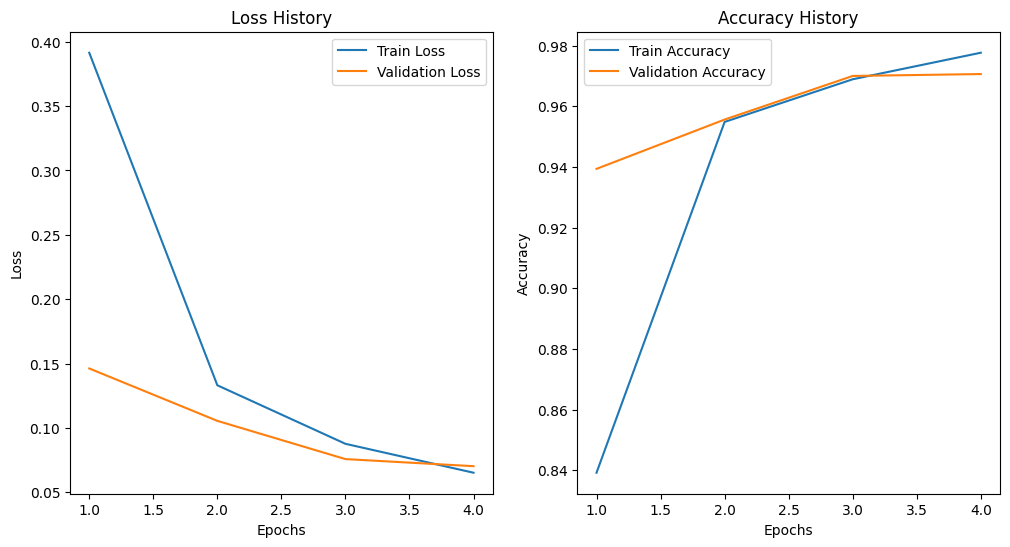

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label="Train Loss")
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss History")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label="Train Accuracy")
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy History")
plt.show()

In [ ]:
model.load_state_dict(torch.load("best_resnet50.pth"))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))


<ipython-input-12-ea48b35b3c35>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet50.pth"))



Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99       816
        Real       0.98      0.99      0.99       784

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600



In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/save models/best_resnet50.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved at {save_path}")

Model saved at /content/drive/MyDrive/Colab Notebooks/save models/best_resnet50.pth


- **load lại model đã lưu với trọng số giống với khi train để khớp với dữ liệu đầu ra**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # 2 nhãn fake và real
)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/save models/best_resnet50_T1.pth", map_location=device))
model.to(device)
model.eval()

print("Model loaded successfully!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


Model loaded successfully!


In [ ]:
test_folder = "/content/drive/MyDrive/Colab Notebooks/testfolder/"
image_files = [f for f in os.listdir(test_folder) if f.endswith(('.jpg', '.png'))]

for image_name in image_files:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Chuyển đổi ảnh thành tensor

    # Chạy mô hình
    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
        _, predicted = torch.max(probabilities, 1)  # Lấy nhãn có xác suất cao nhất

    # Chuyển xác suất thành phần trăm
    fake_prob = probabilities[0, 0].item() * 100  # Xác suất ảnh là "Fake"
    real_prob = probabilities[0, 1].item() * 100  # Xác suất ảnh là "Real"
    class_label = "Fake" if predicted.item() == 0 else "Real"

    # In kết quả với tỷ lệ phần trăm
    print(f"Ảnh {image_name}: {class_label} (Fake: {fake_prob:.2f}%, Real: {real_prob:.2f}%)")

Ảnh fake_34.jpg: Fake (Fake: 99.92%, Real: 0.08%)
Ảnh fake_35.jpg: Fake (Fake: 99.99%, Real: 0.01%)
Ảnh fake_36.jpg: Fake (Fake: 98.73%, Real: 1.27%)
Ảnh fake_37.jpg: Fake (Fake: 99.72%, Real: 0.28%)
Ảnh fake_38.jpg: Fake (Fake: 97.41%, Real: 2.59%)
Ảnh fake_39.jpg: Fake (Fake: 78.58%, Real: 21.42%)
Ảnh fake_40.jpg: Fake (Fake: 99.78%, Real: 0.22%)
Ảnh fake_41.jpg: Fake (Fake: 96.56%, Real: 3.44%)
Ảnh fake_42.jpg: Fake (Fake: 98.74%, Real: 1.26%)
Ảnh fake_43.jpg: Fake (Fake: 94.67%, Real: 5.33%)
Ảnh real_291.jpg: Real (Fake: 8.60%, Real: 91.40%)
Ảnh real_294.jpg: Real (Fake: 16.63%, Real: 83.37%)
Ảnh real_292.jpg: Real (Fake: 16.12%, Real: 83.88%)
Ảnh real_293.jpg: Real (Fake: 0.92%, Real: 99.08%)
Ảnh real_298.jpg: Real (Fake: 0.00%, Real: 100.00%)
Ảnh real_309.jpg: Real (Fake: 0.00%, Real: 100.00%)
Ảnh real_310.jpg: Real (Fake: 0.00%, Real: 100.00%)
Ảnh real_311.jpg: Fake (Fake: 84.34%, Real: 15.66%)
Ảnh real_308.jpg: Real (Fake: 0.58%, Real: 99.42%)
Ảnh real_314.jpg: Real (Fake: 0.22

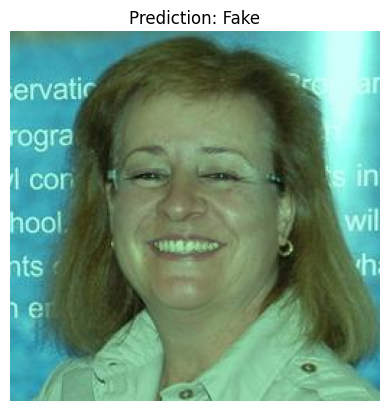

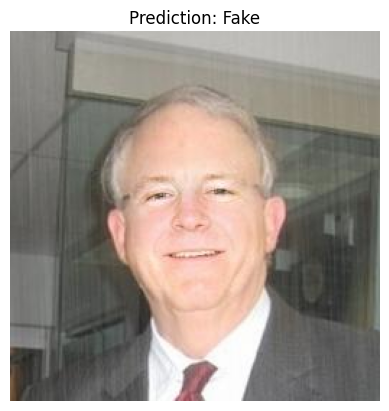

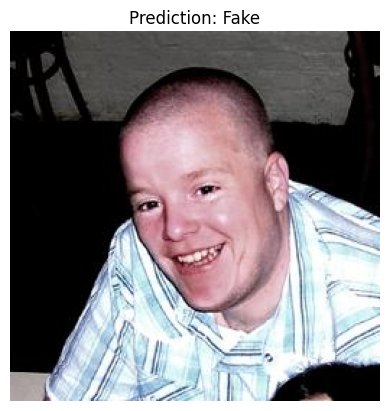

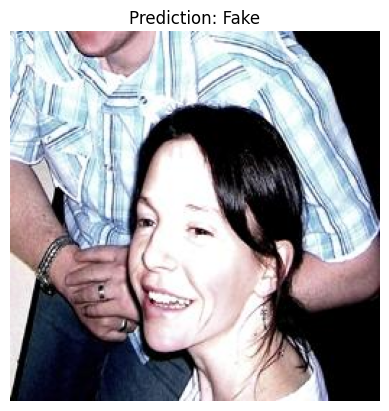

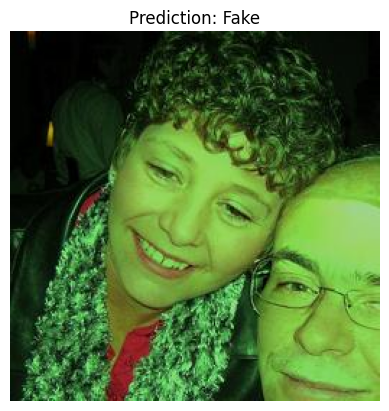

In [ ]:
for image_name in image_files[:5]:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    class_label = "Fake" if predicted.item() == 0 else "Real"

    plt.imshow(image)
    plt.title(f"Prediction: {class_label}")
    plt.axis("off")
    plt.show()

In [ ]:
test_folder = "/content/drive/MyDrive/Colab Notebooks/testthuc/"
image_files = [f for f in os.listdir(test_folder) if f.endswith(('.jpg', '.png'))]

for image_name in image_files:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
        _, predicted = torch.max(probabilities, 1)

    fake_prob = probabilities[0, 0].item() * 100
    real_prob = probabilities[0, 1].item() * 100
    class_label = "Fake" if predicted.item() == 0 else "Real"

    print(f"Ảnh {image_name}: {class_label} (Fake: {fake_prob:.2f}%, Real: {real_prob:.2f}%)")

Ảnh fake_3951.jpg: Fake (Fake: 100.00%, Real: 0.00%)
Ảnh fake_3952.jpg: Real (Fake: 46.10%, Real: 53.90%)
Ảnh imgtest1_real.jpg: Real (Fake: 0.25%, Real: 99.75%)
Ảnh imagetest2_real.jpg: Real (Fake: 0.43%, Real: 99.57%)
Ảnh OIF.jpg: Fake (Fake: 79.33%, Real: 20.67%)
Ảnh bf7ce33517bf96d0d534591b2f3860ba.jpg: Real (Fake: 0.00%, Real: 100.00%)
Ảnh R.jpg: Fake (Fake: 92.97%, Real: 7.03%)


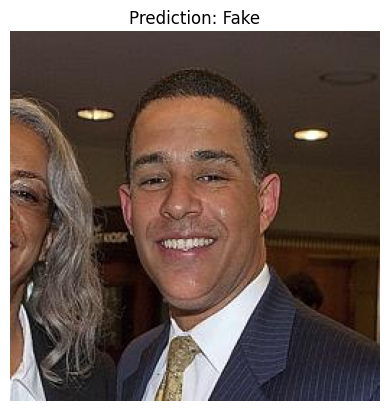

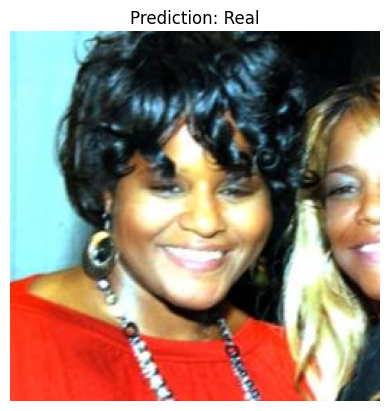

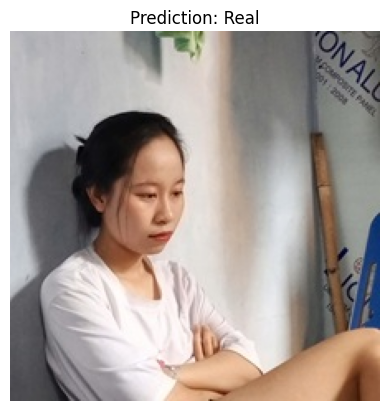

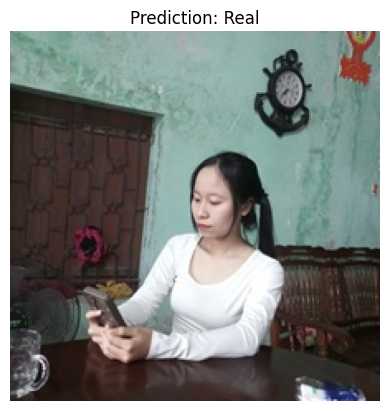

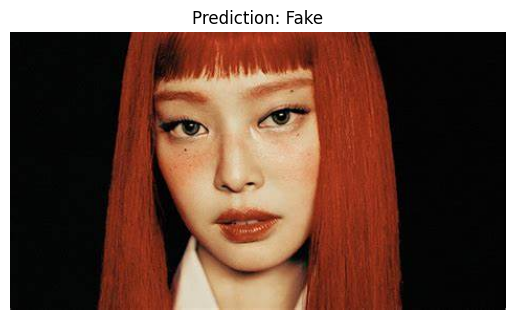

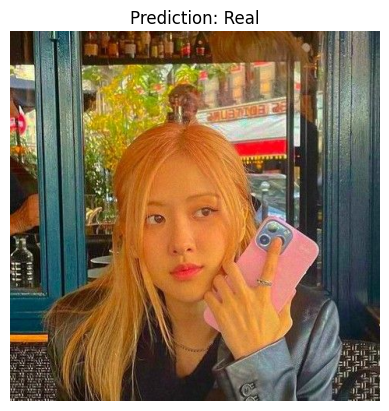

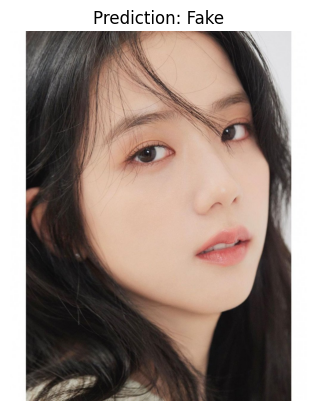

In [ ]:
for image_name in image_files[:8]:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    class_label = "Fake" if predicted.item() == 0 else "Real"

    plt.imshow(image)
    plt.title(f"Prediction: {class_label}")
    plt.axis("off")
    plt.show()

In [ ]:
import pandas as pd

results = [{"image": os.path.basename(img), "prediction": predict_image(img)} for img in image_files]
df = pd.DataFrame(results)
df.to_csv("/content/drive/MyDrive/Colab Notebooks/df_results/test_results.csv", index=False)
print("Saved predictions to test_results.csv")

# **MESONET**
- 1h

In [ ]:
!pip install -q torch torchvision matplotlib numpy opencv-python pillow

In [ ]:
!git clone https://github.com/DariusAf/MesoNet.git

Cloning into 'MesoNet'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 82 (delta 30), reused 26 (delta 25), pack-reused 43 (from 1)
Receiving objects: 100% (82/82), 493.89 KiB | 27.44 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [ ]:
%cd MesoNet

/content/MesoNet


In [ ]:
!cat /content/MesoNet/classifiers.py

# -*- coding:utf-8 -*-

from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam

IMGWIDTH = 256

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        if x.size == 0:
            return []
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)


class Meso1(Classifier):
    """
    Feature extraction + Classification
    """
    def __init__(self, learning_rate = 0.001, dl_rate = 1):
        self.model = self.init_model(dl_rate)
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error

In [ ]:
transform_meso4 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),  #256x256
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset_meso4 = datasets.ImageFolder(root=f"{dataset_path}/Train", transform=transform_meso4)

In [ ]:
import torch.nn.functional as F

class Meso4(nn.Module):
    def __init__(self, num_classes=2):
        super(Meso4, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=5, padding=2)

        self.batchnorm1 = nn.BatchNorm2d(8)
        self.batchnorm2 = nn.BatchNorm2d(8)
        self.batchnorm3 = nn.BatchNorm2d(16)
        self.batchnorm4 = nn.BatchNorm2d(16)

        self.pool = nn.MaxPool2d(2, stride=2, padding=0)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(16, 16)
        self.fc2 = nn.Linear(16, num_classes)

        self.dropout = nn.Dropout(0.5)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))

        x = self.global_pool(x)
        x = torch.flatten(x, 1)

        x = self.dropout(self.leakyrelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 2
batch_size = 32
k_folds = 5
learning_rates = [1e-3, 1e-4, 1e-5]

#KFold
kf = KFold(n_splits=k_folds, shuffle=True)

best_model_meso4 = None
best_acc_meso4 = 0.0

#lưu loss và accuracy
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for lr in learning_rates:
    print(f"\n=== Training Meso4 with Learning Rate: {lr} ===")

    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_meso4)):
        print(f"Fold {fold+1}/{k_folds}")

        train_subsampler_meso4 = Subset(dataset_meso4, train_idx)
        val_subsampler_meso4 = Subset(dataset_meso4, val_idx)

        train_loader_meso4 = DataLoader(train_subsampler_meso4, batch_size=batch_size, shuffle=True)
        val_loader_meso4 = DataLoader(val_subsampler_meso4, batch_size=batch_size, shuffle=False)

        model = Meso4(num_classes=num_classes).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

        best_fold_acc_meso4 = 0.0
        best_fold_model_meso4 = None

        for epoch in range(4): #4epochs
            model.train()
            running_loss, correct_train = 0.0, 0

            for inputs, labels in train_loader_meso4:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                correct_train += (preds == labels).sum().item()
                running_loss += loss.item() * inputs.size(0)

            train_loss = running_loss / len(train_loader_meso4.dataset)
            train_acc = correct_train / len(train_loader_meso4.dataset)
            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)

            model.eval()
            running_val_loss, correct_val = 0.0, 0
            with torch.no_grad():
                for inputs, labels in val_loader_meso4:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    correct_val += (preds == labels).sum().item()
                    running_val_loss += loss.item() * inputs.size(0)

            val_loss = running_val_loss / len(val_loader_meso4.dataset)
            val_acc = correct_val / len(val_loader_meso4.dataset)
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc)

            scheduler.step(val_loss)

            print(f"Epoch {epoch+1}/4: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            if val_acc > best_fold_acc_meso4:
                best_fold_acc_meso4 = val_acc
                best_fold_model_meso4 = copy.deepcopy(model.state_dict())

        if best_fold_acc_meso4 > best_acc_meso4:
            best_acc_meso4 = best_fold_acc_meso4
            best_model_meso4 = best_fold_model_meso4

        fold_results.append(best_fold_acc_meso4)

    print(f"\nAverage Accuracy for LR={lr}: {np.mean(fold_results):.4f}\n")

torch.save(best_model_meso4, "best_meso4.pth")
print("Best Meso4 model saved!")




=== Training Meso4 with Learning Rate: 0.001 ===
Fold 1/5


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/4: Train Loss: 0.6858, Train Acc: 0.5394, Val Loss: 0.6677, Val Acc: 0.6144
Epoch 2/4: Train Loss: 0.6747, Train Acc: 0.5692, Val Loss: 0.6535, Val Acc: 0.6250
Epoch 3/4: Train Loss: 0.6697, Train Acc: 0.5730, Val Loss: 0.6511, Val Acc: 0.6362
Epoch 4/4: Train Loss: 0.6610, Train Acc: 0.5938, Val Loss: 0.6353, Val Acc: 0.6400
Fold 2/5
Epoch 1/4: Train Loss: 0.6826, Train Acc: 0.5480, Val Loss: 0.6577, Val Acc: 0.6500
Epoch 2/4: Train Loss: 0.6705, Train Acc: 0.5847, Val Loss: 0.6494, Val Acc: 0.6269
Epoch 3/4: Train Loss: 0.6674, Train Acc: 0.5934, Val Loss: 0.6487, Val Acc: 0.6631
Epoch 4/4: Train Loss: 0.6552, Train Acc: 0.6150, Val Loss: 0.6428, Val Acc: 0.6656
Fold 3/5
Epoch 1/4: Train Loss: 0.6882, Train Acc: 0.5345, Val Loss: 0.6655, Val Acc: 0.6288
Epoch 2/4: Train Loss: 0.6742, Train Acc: 0.5741, Val Loss: 0.6487, Val Acc: 0.6306
Epoch 3/4: Train Loss: 0.6638, Train Acc: 0.6089, Val Loss: 0.6475, Val Acc: 0.6525
Epoch 4/4: Train Loss: 0.6530, Train Acc: 0.6112, Val Loss

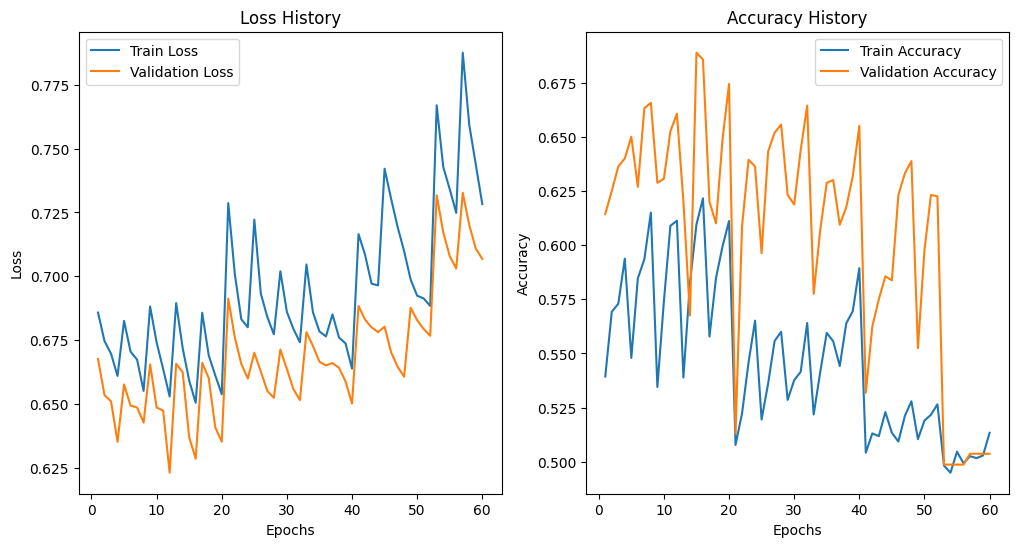

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label="Train Loss")
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss History")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label="Train Accuracy")
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy History")
plt.show()

In [ ]:
# Load mô hình tốt nhất Meso4
model.load_state_dict(torch.load("best_meso4.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in val_loader_meso4:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

#classification report
target_names = ["Fake", "Real"]
print("\nClassification Report for Meso4:")
print(classification_report(y_true, y_pred, target_names=target_names))


<ipython-input-24-7fb909b13c5f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_meso4.pth"))



Classification Report for Meso4:
              precision    recall  f1-score   support

        Fake       0.68      0.63      0.65       794
        Real       0.66      0.70      0.68       806

    accuracy                           0.67      1600
   macro avg       0.67      0.67      0.67      1600
weighted avg       0.67      0.67      0.67      1600



In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/save models/best_meso4.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved at {save_path}")

Model saved at /content/drive/MyDrive/Colab Notebooks/save models/best_meso4.pth


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_meso4 = Meso4(num_classes=2)
model_meso4.load_state_dict(torch.load("best_meso4.pth", map_location=device))
model_meso4.to(device)
model_meso4.eval()

print("Meso4 model loaded successfully!")


Meso4 model loaded successfully!


<ipython-input-35-e7b5b2bcf853>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_meso4.load_state_dict(torch.load("best_meso4.pth", map_location=device))


- dự đoán sai nhiều so với nhãn gốc

In [ ]:
test_folder = "/content/drive/MyDrive/Colab Notebooks/testfolder/"
image_files = [f for f in os.listdir(test_folder) if f.endswith(('.jpg', '.png'))]

for image_name in image_files:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  #batch dimension

    with torch.no_grad():
        output = model_meso4(image)
        _, predicted = torch.max(output, 1)

    class_label = "Fake" if predicted.item() == 0 else "Real"
    print(f"Ảnh {image_name}: {class_label}")

Ảnh fake_34.jpg: Real
Ảnh fake_35.jpg: Fake
Ảnh fake_36.jpg: Real
Ảnh fake_37.jpg: Real
Ảnh fake_38.jpg: Real
Ảnh fake_39.jpg: Real
Ảnh fake_40.jpg: Real
Ảnh fake_41.jpg: Real
Ảnh fake_42.jpg: Real
Ảnh fake_43.jpg: Real
Ảnh real_291.jpg: Real
Ảnh real_294.jpg: Fake
Ảnh real_292.jpg: Real
Ảnh real_293.jpg: Real
Ảnh real_298.jpg: Real
Ảnh real_309.jpg: Real
Ảnh real_310.jpg: Real
Ảnh real_311.jpg: Real
Ảnh real_308.jpg: Fake
Ảnh real_314.jpg: Real


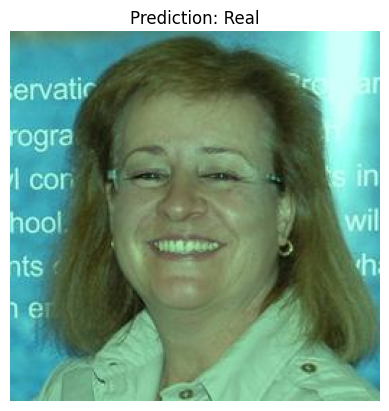

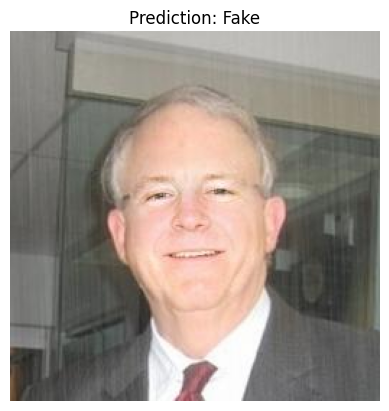

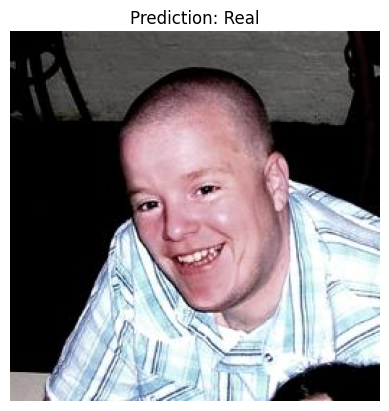

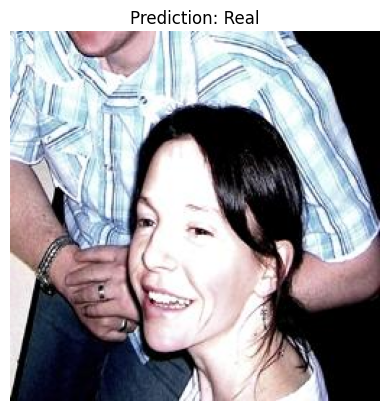

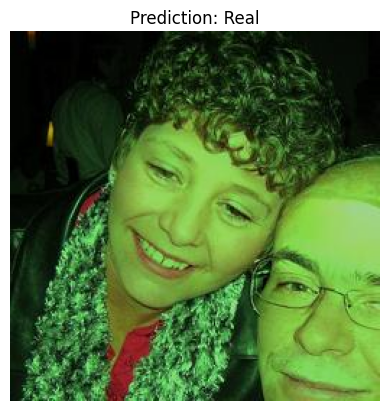

In [ ]:
for image_name in image_files[:5]:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model_meso4(input_tensor)
        _, predicted = torch.max(output, 1)

    class_label = "Fake" if predicted.item() == 0 else "Real"

    plt.imshow(image)
    plt.title(f"Prediction: {class_label}")
    plt.axis("off")
    plt.show()

In [ ]:
test_folder = "/content/drive/MyDrive/Colab Notebooks/testthuc/"
image_files = [f for f in os.listdir(test_folder) if f.endswith(('.jpg', '.png'))]

for image_name in image_files:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  #batch dimension

    with torch.no_grad():
        output = model_meso4(image)
        _, predicted = torch.max(output, 1)

    class_label = "Fake" if predicted.item() == 0 else "Real"
    print(f"Ảnh {image_name}: {class_label}")

Ảnh imgtest1_real.jpg: Real
Ảnh fake_3952.jpg: Real
Ảnh fake_3951.jpg: Real
Ảnh imagetest2_real.jpg: Real


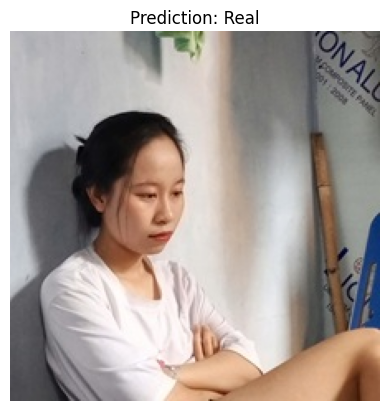

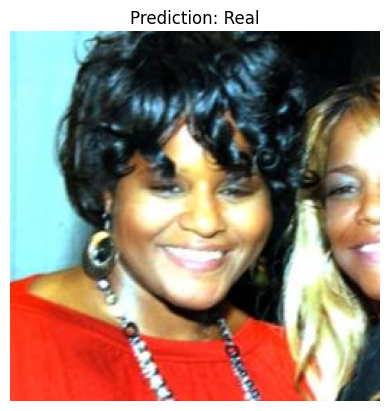

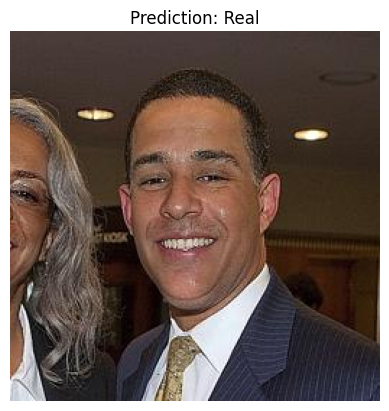

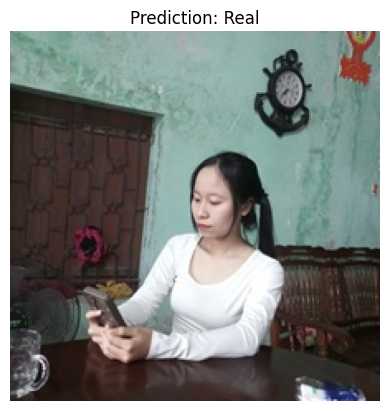

In [ ]:
for image_name in image_files[:4]:
    image_path = os.path.join(test_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model_meso4(input_tensor)
        _, predicted = torch.max(output, 1)

    class_label = "Fake" if predicted.item() == 0 else "Real"

    plt.imshow(image)
    plt.title(f"Prediction: {class_label}")
    plt.axis("off")
    plt.show()

# **COMPARE RESNET50 & MESO4**

- resnet50

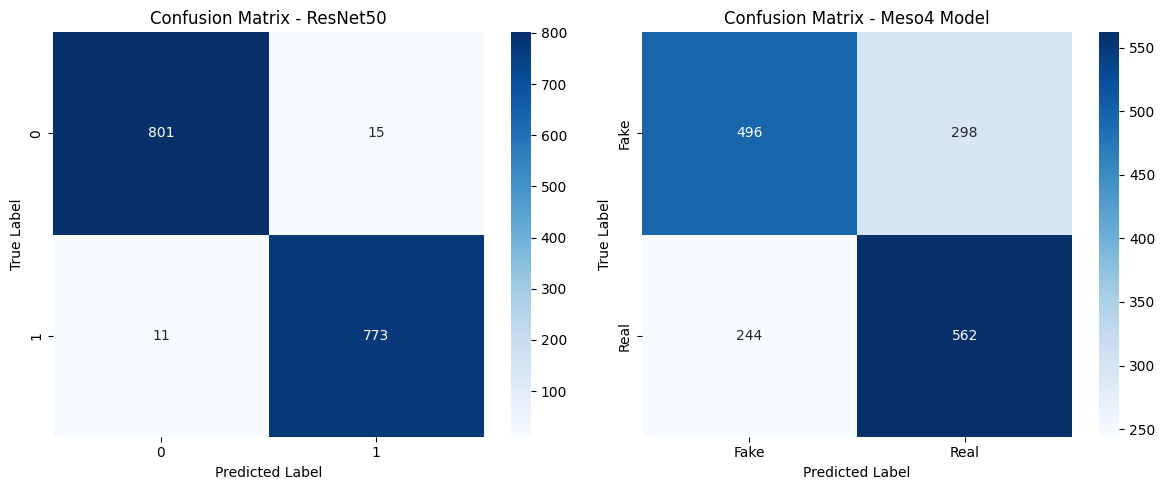

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# === ResNet50 ===
all_preds_resnet = []
all_labels_resnet = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs) #resnet50
        _, preds = torch.max(outputs, 1)

        all_preds_resnet.extend(preds.cpu().numpy())
        all_labels_resnet.extend(labels.cpu().numpy())

cm_resnet = confusion_matrix(all_labels_resnet, all_preds_resnet)

sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes), ax=axes[0])
axes[0].set_title("Confusion Matrix - ResNet50")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# === Meso4 ===
all_preds_meso4 = []
all_labels_meso4 = []

with torch.no_grad():
    for inputs, labels in val_loader_meso4:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_meso4(inputs) #meso4
        _, preds = torch.max(outputs, 1)

        all_preds_meso4.extend(preds.cpu().numpy())
        all_labels_meso4.extend(labels.cpu().numpy())

cm_meso4 = confusion_matrix(all_labels_meso4, all_preds_meso4)

sns.heatmap(cm_meso4, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'], ax=axes[1])
axes[1].set_title("Confusion Matrix - Meso4 Model")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()
